First we import all the packages.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

We define the training parameters:

*   Number of epochs: Specifies the number of complete passes through the entire training dataset during the training process.
*   Batch size: Defines the number of training samples used in one iteration of the training process.
* Learning rate: Controls how much to change the model's weights with respect to the loss gradient during each optimization step.


In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 1
batch_size = 128
learning_rate = 1e-3

Download the dataset. In this case, we will use the MNIST dataset. The MNIST dataset (Modified National Institute of Standards and Technology) is a benchmark dataset widely used in machine learning and image classification. It consists of 70,000 handwritten digits (0-9) in grayscale, with 60,000 images for training and 10,000 for testing. Each image is 28x28 pixels.

In [41]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

**Exercise 1**: Try different samples! Modify the *sample* variable to get different handwritten numbers contained in the dataset.

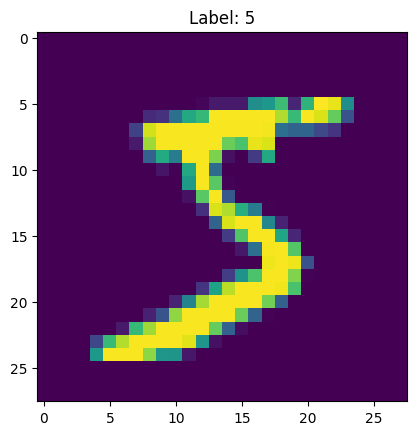

In [42]:
sample = 0

# Select a sample image and label from the training dataset
sample_img, sample_label = train_dataset[sample]  # Get the first sample

# Plot the image with its label
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"Label: {sample_label}")
plt.show()

Create the data loaders. These objects facilitate the efficient loading and batching of the training and testing datasets, with shuffling applied to the training data to enhance model training.

In [43]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Define the network. In this case, we will use a Convolutional Autoencoder. The different elemnts are the following:

*   Encoder: This part uses a series of convolutional layers followed by ReLU activations to compress the input image (28x28 grayscale) into a lower-dimensional latent representation (10-dimensional). The encoder reduces the spatial dimensions through strided convolutions while increasing the depth of the feature maps.

* Decoder: This part takes the 10-dimensional latent vector and reconstructs the original image. It uses fully connected layers and transposed convolutions to gradually upsample the data back to the original image size (28x28). The final output layer applies a sigmoid activation function to ensure the output values are in the range [0, 1], suitable for grayscale images.

* Forward Method: The forward function defines the forward pass of the network, where the input is processed through the encoder to obtain the latent representation, which is then passed through the decoder to reconstruct the original image. The method returns both the reconstructed image and the latent representation.



In [44]:
# Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, img_size, img_channels):
        super(ConvAutoencoder, self).__init__()

        self.img_channels = img_channels
        self.img_size = img_size
        conv_output_size = img_size // 4  # Assuming 2 conv layers with stride=2 halves size each time

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 16, 3, stride=2, padding=1),  # Output: [16, img_size/2, img_size/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: [32, img_size/4, img_size/4]
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(32 * conv_output_size * conv_output_size, 10)  # Adapt to flattened size
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32 * conv_output_size * conv_output_size),
            nn.Unflatten(1, (32, conv_output_size, conv_output_size)),  # Reshape to [32, img_size/4, img_size/4]
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: [16, img_size/2, img_size/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, img_channels, 3, stride=2, padding=1, output_padding=1),  # Output: [img_channels, img_size, img_size]
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

model = ConvAutoencoder(img_size=28, img_channels=1).to(device)

Define the network optimizer. In this case we are using the Adam optimizer, a popular optimization algorithm that combines the benefits of two other extensions of stochastic gradient descent (SGD): AdaGrad and RMSProp. Adam adapts the learning rate for each parameter based on the first and second moments of the gradients, making it efficient and effective for training deep learning models.

In [45]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**Exercise 2**: Try the untrained network! Modify the *sample* variable to see the latent representation and reconstruction of several handwritten numbers from the dataset. Note that the results are very bad, we haven't trained the network yet.

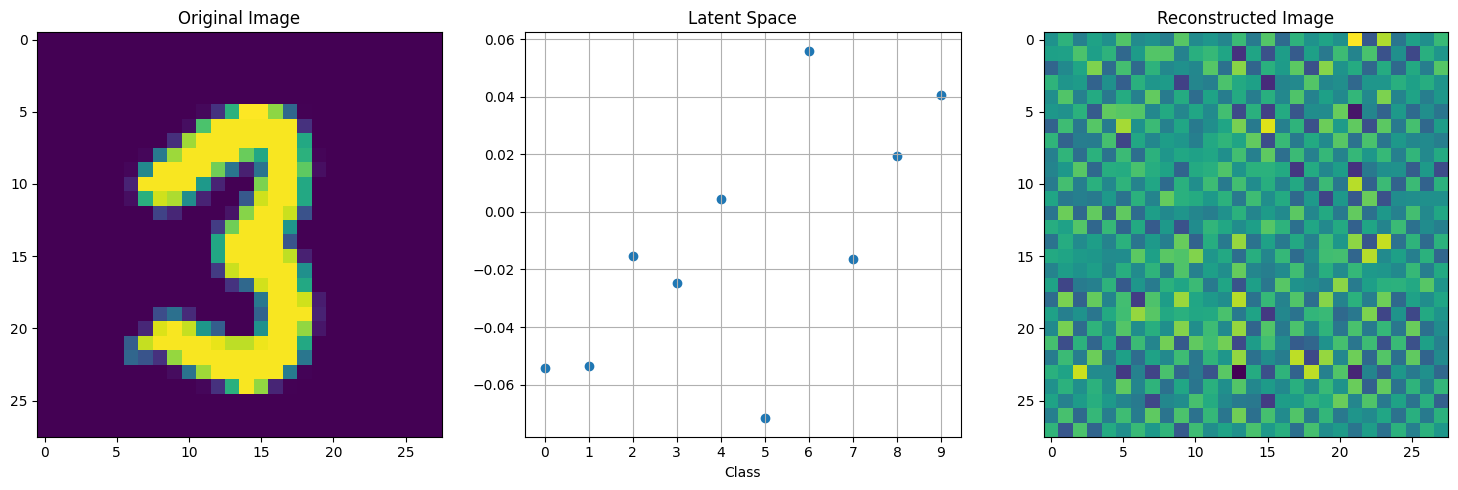

In [46]:
sample = 2

# Evaluation and Visualization
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, labels = data
        img = img.to(device)
        img_net, label_net = model(img)
        # You can use the encoded features for classification or other downstream tasks
        # by extracting them from the encoder part of the model (model.encoder(img)).

# Example to visualize a reconstructed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[sample].permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.scatter(range(0, 10), label_net[sample].cpu().numpy())
plt.xticks(range(0, 10))
plt.xlabel("Class")
plt.title("Latent Space")
plt.grid()

plt.subplot(1, 3, 3)
plt.imshow(img_net[sample].permute(1, 2, 0).cpu().numpy())
plt.title("Reconstructed Image")

plt.tight_layout()  # Add this line to adjust subplot params for a tight layout
plt.show()

Training loop. This loop iteratively feeds batches of data through the model, computes the reconstruction and classification losses, performs backpropagation, and updates the model parameters, all while tracking and displaying the loss for each epoch.

In [47]:
# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        img, label = data
        img = img.to(device)
        label = label.to(device)

        # Forward pass
        img_net, label_net = model(img)
        # Reconstruction and classification loss
        loss = F.mse_loss(img_net, img) + F.cross_entropy(label_net, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/1], Loss: 0.2646


Model evaluation. Here we apply the model to the test dataset, which was not seen before by the neural network.

In [48]:
# Evaluation and Visualization
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, labels = data
        img = img.to(device)
        img_net, label_net = model(img)

**Exercise 3**: Try the trained network! Let's see the performance of the trained network. We expect that after the optimization, the handwritten numbers are correctly classified and reconstructed.

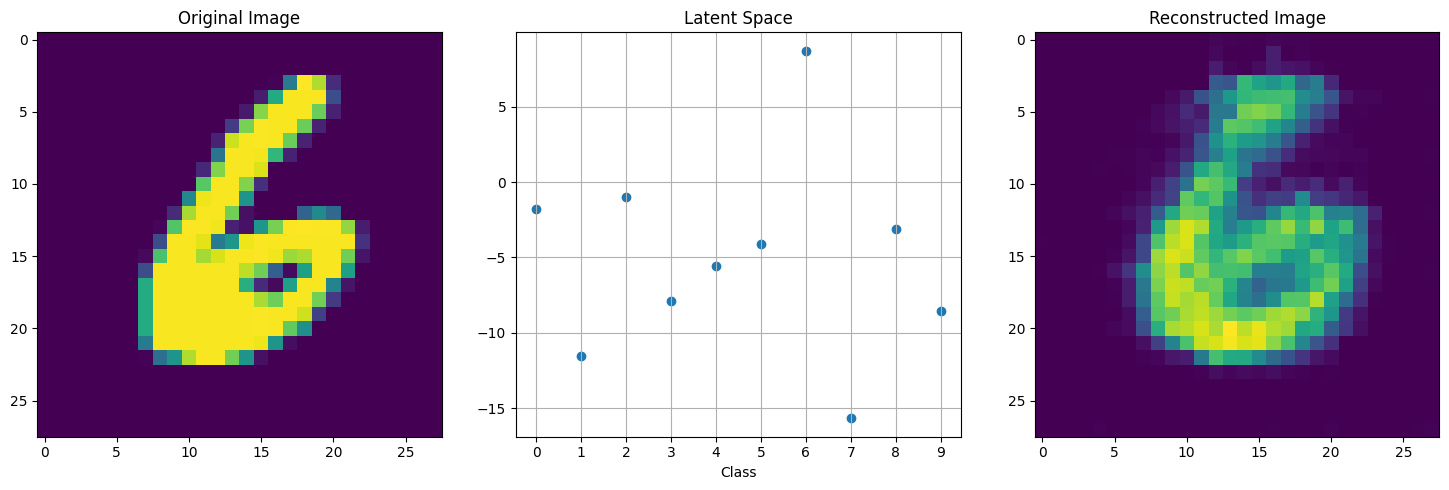

In [51]:
sample = 5

# Example to visualize a reconstructed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[sample].permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.scatter(range(0, 10), label_net[sample].cpu().numpy())
plt.xticks(range(0, 10))
plt.xlabel("Class")
plt.title("Latent Space")
plt.grid()

plt.subplot(1, 3, 3)
plt.imshow(img_net[sample].permute(1, 2, 0).cpu().numpy())
plt.title("Reconstructed Image")

plt.tight_layout()  # Add this line to adjust subplot params for a tight layout
plt.show()

**Exercise 4**: Try to generate new numbers! The cool thing about having interpretable latent variables is that we can generate new samples which never existed in the original MNIST dataset. We will manually select the 10 dimensional latent vector so that we can generate new numbers. Try to change the latent vector components to create specific numbers, or even create a combination of numbers.

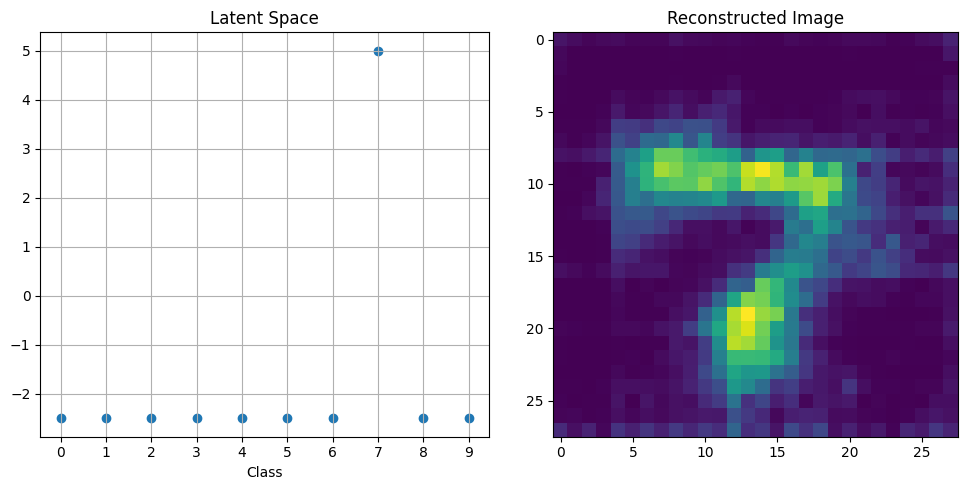

In [52]:
# Latent vector: Class    0     1     2     3     4     5     6    7     8     9
latent = torch.tensor([[-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, 5.0, -2.5, -2.5]]). to(device)
model.eval()
with torch.no_grad():
  img_generated = model.decoder(latent)

# Example to visualize a generated image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(range(0, 10), latent.cpu().numpy())
plt.xticks(range(0, 10))
plt.xlabel("Class")
plt.title("Latent Space")
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(img_generated[0].permute(1, 2, 0).cpu().numpy())
plt.title("Reconstructed Image")

plt.tight_layout()  # Add this line to adjust subplot params for a tight layout
plt.show()

**Exercise 5**: Try to change the dataset! We have used the MNIST dataset, but there are many of others. For example:

*   CIFAR-10: The CIFAR-10 dataset contains 60,000 color images in 10 different classes (e.g., airplane, car, bird) with 6,000 images per class. Each image is 32x32 pixels.
*   Fashion MNIST: This dataset is a drop-in replacement for MNIST, consisting of 70,000 grayscale images of clothing items (e.g., T-shirts, shoes) instead of digits. Each image is also 28x28 pixels.
* CIFAR-100: Similar to CIFAR-10, CIFAR-100 consists of 60,000 color images, but it contains 100 classes with 600 images per class. Each image is also 32x32 pixels.

Using this notebook as a reference, you can explore any of these new datasets with minimal changes in the code. Make sure that the image dimensions and the latent dimensions are consistent with the dimensions of the new dataset.


